In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", message="X has feature names, but StandardScaler was fitted without feature names")


In [3]:
# For Local
# TrainSource = "./GeneratedData/TrainData.pickle"
# TestSource = "./GeneratedData/TestData.pickle"

# FileSource = "./GeneratedData4CO/allData.pickle"
FileSource = "./GeneratedDataDouble/allData.pickle"
NYC_FileSource = "./GeneratedDataDouble/NYC_allData.pickle"
ISR_FileSource = "./GeneratedDataDouble/ISR_allData.pickle"

ScalerPath = "./Model/Scaler.pickle"
ClfRNNModelPath = "./Model/Clf_Model.pickle"
# NYC_AccelRNNModelPath = "./Model/NYC_AccelRNNModel.pickle"
# ISR_AccelRNNModelPath = "./Model/ISR_AccelRNNModel.pickle"
# CORNNModelPath = "./GeneratedData/CORNNModel.pickle"

In [4]:
FileList=[]
with open(FileSource,'rb') as f:
    FileList = pickle.load(f)

HeaderWithoutAccel = ["ApproachRateOther", 
                      "Rel_Pos_Magnitude", 
                      "1_Head_Center_Distance", "2_Head_Center_Distance", 
                      # "Filtered_1_Head_Velocity_Total",
                      "Filtered_2_Head_Velocity_Total"
                    #   "1_Turn",
                    #   "2_Indicator",
                    #   "Centerline_Offset_2",
                    #   "RelativeRotation"
                      ] # Signaling ()

# outputHeader = ["Centerline_Offset_A"]
outputHeader = ["Cat_Accel1"]
                
input_size = len(HeaderWithoutAccel)
output_size = len(outputHeader)
hidden_size = 6

In [5]:
with open(FileSource,'rb') as f:
    FileList = pickle.load(f)

In [6]:
Seq_Length = 5
TargetTimeLength = 0.75 ## in seconds

timeDiffArray=np.empty(0)
for file_path in FileList:
    if not os.path.exists(file_path):
      print(f"Could not find{file_path}")
      continue
    data = pd.read_feather(file_path)
    timeDiffArray = np.append(timeDiffArray, np.diff(data["ScenarioTime"]))
Seq_Length = int(np.floor(TargetTimeLength/np.mean(timeDiffArray)))
Seq_Length

13

In [7]:
## First scale Input
scaler=None
if os.path.exists(ScalerPath) and False:
  with open(ScalerPath, 'rb') as file:
    scaler = pickle.load(file)
else:
  scaler = StandardScaler()
  for file_path in FileList:
    if not os.path.exists(file_path):
      print(f"Could not find{file_path}")
      continue
    data = pd.read_feather(file_path)
    features = data[HeaderWithoutAccel]
    scaler.partial_fit(features.values)
  with open(ScalerPath, 'wb') as file:
    pickle.dump(scaler, file)

In [8]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU layer: processes sequences
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize the hidden state for the first sequence
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate through GRU
        out, _ = self.rnn(x, h0)  # out shape: (batch_size, sequence_length, hidden_size)

        # Use the hidden state from the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Pass through the fully connected layer
        out = self.fc(out)  # Shape: (batch_size, output_size)
        
        prob = F.softmax(out, dim=1)
        return prob


In [9]:
def create_sequences(features, targets, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length), :]
        y = targets.iloc[i + seq_length].values[0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Load and preprocess data from each file
def preprocess_data(files, seq_length):
    all_sequences = np.empty((0,seq_length,len(HeaderWithoutAccel)))
    all_targets = np.empty(0)

    for file_path in files:
        data = pd.read_feather(file_path)
        features = data[HeaderWithoutAccel]
        targets = data[outputHeader]
        scaled_features = scaler.transform(features)
        sequences, targetsVector = create_sequences(scaled_features,targets, seq_length)
        if(sequences.shape[0]==0):
          print("Skipping:", all_sequences.shape,sequences.shape)
          continue
        all_sequences = np.concatenate((all_sequences, sequences), axis=0)
        all_targets =  np.concatenate((all_targets, targetsVector), axis=0)

    return all_sequences,all_targets

In [10]:
train_files, test_files = train_test_split(FileList, test_size=0.2, random_state=42)

In [11]:
batch_size = 64

# Prepare the DataLoaders
train_sequences, train_labels = preprocess_data(train_files, Seq_Length)
test_sequences, test_labels = preprocess_data(test_files, Seq_Length)

# Convert to PyTorch tensors
train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)  # Ensure labels are of type Long
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)  # Ensure labels are of type Long

# Create DataLoader for training and testing
train_dataset = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Set parameters
input_size = 5  # Number of features per time step
hidden_size = 32  # Number of GRU units
output_size = 2   # Number of output classes for binary classification
num_layers = 1   # Number of GRU layers
num_epochs = 10
batch_size = 64
seq_length = 13   # Length of each input sequence

# Create the model
net = GRUModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()  # Use BCEWithLogitsLoss for output_size=1
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [13]:
# Track loss and accuracy for each epoch
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        targets = targets.long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    # Calculate average loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    # Print loss and accuracy for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    
    # Evaluate on test data
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_accuracy = correct / total * 100
    test_accuracies.append(test_accuracy)

# Print final test accuracy
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

Epoch [1/10], Loss: 0.5696, Accuracy: 72.23%
Epoch [2/10], Loss: 0.5321, Accuracy: 76.89%
Epoch [3/10], Loss: 0.5181, Accuracy: 78.45%
Epoch [4/10], Loss: 0.5085, Accuracy: 79.47%
Epoch [5/10], Loss: 0.5013, Accuracy: 80.33%
Epoch [6/10], Loss: 0.4965, Accuracy: 80.89%
Epoch [7/10], Loss: 0.4925, Accuracy: 81.34%
Epoch [8/10], Loss: 0.4894, Accuracy: 81.65%
Epoch [9/10], Loss: 0.4863, Accuracy: 82.02%
Epoch [10/10], Loss: 0.4835, Accuracy: 82.32%
Final Test Accuracy: 80.97%


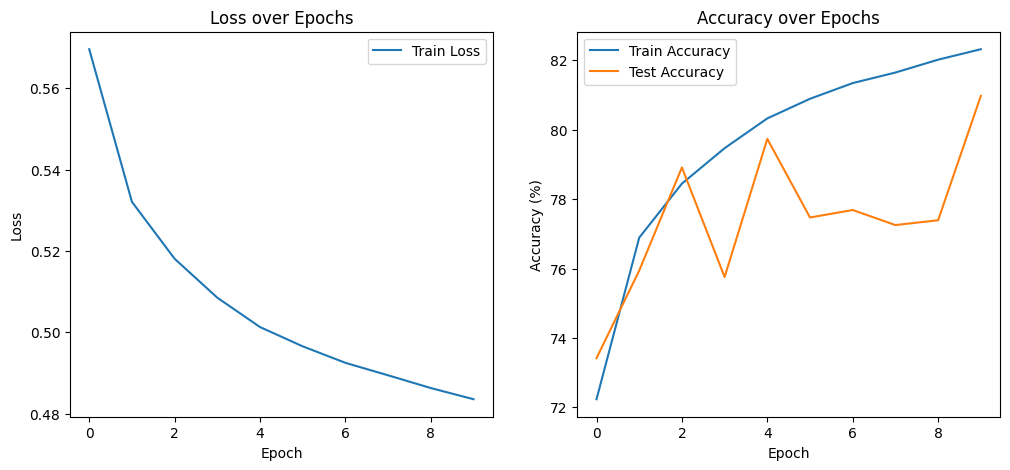

In [14]:
# Plot loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

In [15]:
# def DrawPicture(file, net, Seq_Length):
file = './GeneratedDataDouble/CP5_NYC24_1A.feather'
# print(file)
net.eval()
data = pd.read_feather(file)
features = data[HeaderWithoutAccel]
targets = data[outputHeader]
scaled_features = scaler.transform(features)
sequences, targetsVector = create_sequences(scaled_features,targets, Seq_Length)
# print(sequences.shape)|
out = net(torch.Tensor(sequences)).detach().numpy()

In [16]:
out[:,1].shape

(412,)

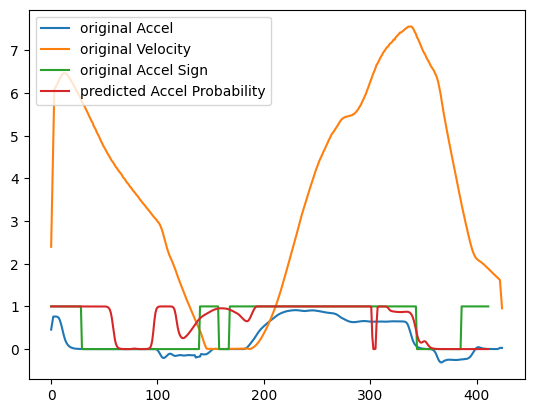

In [17]:
plt.plot(data['Filtered_Accel1'], label='original Accel')
plt.plot(data['Filtered_1_Head_Velocity_Total'], label='original Velocity')
plt.plot(targetsVector,label='original Accel Sign')
plt.plot(out[:,1],label='predicted Accel Probability')
# plt.ylim(-1,1)
plt.legend()
plt.show()

In [18]:
torch.save(net.state_dict(), ClfRNNModelPath)